In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import random
from models import GCN

import matplotlib.pyplot as plt

from sklearn import metrics
from utils import get_plot


In [2]:
from data_process import generate_data, load_data
from train_func import test, train, Block_matrix_train, Lhop_Block_matrix_train, Communicate_train, ADMM_communication_train, Block_matrix_train_batch

In [3]:
def get_K_hop_neighbors(adj_matrix, index, K):
    adj_matrix = adj_matrix + torch.eye(adj_matrix.shape[0],adj_matrix.shape[1])  #make sure the diagonal part >= 1
    hop_neightbor_index=index
    for i in range(K):
        hop_neightbor_index=torch.unique(torch.nonzero(adj[hop_neightbor_index])[:,1]) #include 1-k hop neightbors
    return hop_neightbor_index

In [4]:
def get_gradient_two_layer(features, adj_2_hop, adj_1_hop, number_of_datapoints):
    #adj_2_hop = normalize(adj_2_hop)
    #adj_1_hop = normalize(adj_1_hop)
    return torch.norm(features.T.mm(adj_2_hop.T).mm(adj_1_hop.T).mm(adj_1_hop).mm(adj_2_hop).mm(features)) / number_of_datapoints

In [5]:
import scipy.sparse as sp
def normalize(mx):
    """Row-normalize sparse matrix"""
    
    mx = mx + torch.eye(mx.shape[0],mx.shape[1])
    
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return torch.tensor(mx)

In [6]:

def get_graph(dataset_name, iid_percent, K_over_class_num):
    
        if dataset_name=='simulate':
            

            number_of_nodes=200
            class_num=3
            link_inclass_prob=10/number_of_nodes  #when calculation , remove the link in itself
            #EGCN good when network is dense 20/number_of_nodes  #fails when network is sparse. 20/number_of_nodes/5
            link_outclass_prob=link_inclass_prob/20
            features, adj, labels, idx_train, idx_val, idx_test =generate_data(number_of_nodes,  class_num, link_inclass_prob, link_outclass_prob)               
        else:
            #'cora', 'citeseer', 'pubmed' #other dataset twitter, 
            

            features, adj, labels, idx_train, idx_val, idx_test = load_data(dataset_name)
            class_num = labels.max().item() + 1


        #client num
        K = K_over_class_num * class_num
        
        
        split_data_indexes=[]
        
        nclass=labels.max().item() + 1
        split_data_indexes = []
        non_iid_percent = 1 - float(iid_percent)
        iid_indexes = [] #random assign
        shuffle_labels = [] #make train data points split into different devices
        for i in range(K):
            current = torch.nonzero(labels == i).reshape(-1)
            current = current[np.random.permutation(len(current))] #shuffle
            shuffle_labels.append(current)
                
        average_device_of_class = K // nclass
        if K % nclass != 0: #for non-iid
            average_device_of_class += 1
        for i in range(K):  
            label_i= i // average_device_of_class    
            labels_class = shuffle_labels[label_i]

            average_num= int(len(labels_class)//average_device_of_class * non_iid_percent)
            split_data_indexes.append(np.array(labels_class[average_num * (i % average_device_of_class):average_num * (i % average_device_of_class + 1)]))
        
        L = []
        for i in split_data_indexes:
            L += list(i)
        L.sort()
        iid_indexes = np.setdiff1d(range(len(labels)), L)
        
        for i in range(K):  #for iid
            label_i= i // average_device_of_class
            labels_class = shuffle_labels[label_i]

            average_num= int(len(labels_class)//average_device_of_class * (1 - non_iid_percent))
            split_data_indexes[i] = list(split_data_indexes[i]) + list(iid_indexes[:average_num])
                    
            iid_indexes = iid_indexes[average_num:]
        
        
        #get train indexes in each device, only part of nodes in each device have labels in the train process
        split_train_ids = []
        for i in range(K):
            split_data_indexes[i].sort()
            inter = np.intersect1d(split_data_indexes[i], idx_train)
            split_train_ids.append(np.searchsorted(split_data_indexes[i], inter))   #local id in block matrix

        one_hot_labels = F.one_hot(labels).float()
        
        return features, adj, labels, one_hot_labels, split_data_indexes, K


# Communication Cost

In [27]:

import numpy as np
np.random.seed(42)
torch.manual_seed(42)
dataset_name='simulate'
args_normalize = True


for percent in range(0, 11, 1):
    length_current_index = []
    length_neighbor1 = []
    length_neighbor2 = []
    
    for i in range(10):
        iid_percent = percent / 10
        K_over_class_num = 1
        node_num = 200
        Class_num = 3

        link_inclass_prob=10/node_num  #when calculation , remove the link in itself
        link_outclass_prob=link_inclass_prob/20
        
        features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)


        
        L = []
        for i in range(Class_num-1):
            L+= [i] * int(node_num / Class_num)
        L += [Class_num-1] * (node_num - len(L))
        
        Theta = F.one_hot(torch.tensor(L)).float()
        #L = [1 / Class_num] * Class_num
        #Theta = torch.tensor([L for i in range(node_num)]).float()

        #Lambda = torch.eye(Class_num)
        A = torch.eye(Class_num) * link_inclass_prob

        B = link_outclass_prob * (torch.ones((Class_num, Class_num)) - torch.eye(Class_num))

        Lambda = A+B


        adj = Theta.mm(Lambda).mm(Theta.T)
        features = torch.eye(len(adj))
        one_hot_labels = Theta 
        adj = normalize(adj)
        #get_gradient_two_layer(features, adj_2_hop, adj_1_hop, number_of_datapoints)
        
        p= iid_percent
        
        non_iid_num = int(node_num / Class_num * p)

        Local_index = list(range(int(node_num / Class_num * p))) + list(np.random.randint(int(node_num / Class_num) + 1,node_num, int(node_num / Class_num * (1-p))))
        print(Local_index)


[118, 78, 105, 196, 197, 179, 167, 179, 147, 179, 68, 196, 120, 153, 195, 192, 196, 119, 134, 189, 104, 90, 135, 182, 164, 163, 190, 136, 159, 69, 156, 162, 118, 194, 105, 148, 170, 195, 77, 108, 165, 73, 156, 178, 126, 179, 68, 195, 114, 103, 75, 165, 114, 197, 120, 186, 182, 141, 179, 170, 150, 178, 165, 159, 194, 176]
[162, 67, 135, 70, 82, 90, 146, 68, 194, 150, 190, 99, 167, 78, 133, 131, 140, 109, 110, 95, 78, 161, 112, 196, 101, 147, 156, 74, 159, 156, 181, 171, 124, 180, 141, 186, 87, 167, 165, 102, 162, 103, 78, 179, 79, 89, 165, 171, 96, 83, 179, 128, 150, 178, 152, 85, 166, 142, 75, 94, 194, 118, 149, 177, 183, 135]
[184, 69, 189, 116, 78, 120, 199, 123, 178, 113, 151, 132, 141, 169, 104, 116, 164, 148, 96, 145, 157, 118, 145, 96, 172, 117, 147, 199, 95, 198, 140, 83, 150, 135, 100, 72, 119, 192, 109, 181, 177, 146, 161, 184, 74, 198, 170, 198, 91, 162, 159, 127, 188, 117, 87, 71, 158, 127, 88, 136, 67, 199, 78, 156, 112, 100]
[129, 119, 170, 170, 105, 133, 108, 81, 177, 99,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 81, 69, 109, 133, 122, 129, 81, 175, 182, 158, 113, 123, 116, 137, 148, 182, 171, 154, 68, 170, 150, 109, 137, 160, 108, 199, 131, 100, 186, 67, 196, 127, 154, 134, 193, 88, 148, 195, 96, 192, 163, 90, 80, 102, 90, 161]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 86, 114, 196, 103, 195, 198, 166, 120, 188, 91, 197, 75, 100, 109, 140, 160, 88, 136, 196, 160, 98, 172, 67, 138, 116, 81, 119, 74, 140, 112, 135, 180, 189, 183, 109, 86, 87, 148, 123, 140, 164, 176, 181, 108, 134, 136]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 118, 154, 123, 149, 132, 86, 99, 138, 91, 112, 139, 164, 123, 153, 199, 121, 127, 155, 74, 82, 182, 127, 81, 197, 168, 120, 80, 102, 171, 148, 133, 76, 115, 177, 131, 123, 93, 179, 199, 137, 149, 123, 186, 159, 81, 177]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 161, 100, 187, 81, 186, 162, 72, 175, 163, 98, 149, 184,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 104, 152, 179, 178, 120, 112, 70, 128, 190, 194, 178, 151, 70, 131, 128, 156, 186, 196, 111, 178]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 143, 84, 169, 136, 185, 163, 101, 135, 192, 165, 144, 177, 83, 70, 158, 141, 169, 90, 131, 183]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 111, 125, 78, 99, 87, 126, 118, 189, 172, 166, 137, 128, 154, 90, 106, 142, 75, 69, 87, 161]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 79, 70, 69, 1

In [32]:
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
dataset_name='cora'
args_normalize = True

List_length_current_index = []
List_length_neighbor1 = []
List_length_neighbor2 = []


for percent in range(0, 11, 1):
    length_current_index = []
    length_neighbor1 = []
    length_neighbor2 = []
    
    for times in range(10):
        iid_percent = percent / 10
        K_over_class_num = 1
        features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
        if dataset_name=='simulate':
                feature = one_hot_labels
        if args_normalize:
            adj = normalize(adj)

        for i in range(len(split_data_indexes)):
                current_index = split_data_indexes[i]

                neighbor1 = get_K_hop_neighbors(adj, current_index, 1)

                neighbor2 = get_K_hop_neighbors(adj, current_index, 2)

                #print(len(current_index), len(neighbor1), len(neighbor2))
                length_current_index.append(len(current_index))
                length_neighbor1.append(len(neighbor1))
                length_neighbor2.append(len(neighbor2))
        print(np.array(length_current_index).sum() / len(length_current_index))
        print(np.array(length_neighbor1).sum() / len(length_neighbor1))
        print(np.array(length_neighbor2).sum() / len(length_neighbor2))
    
    List_length_current_index.append(np.array(length_current_index).sum() / len(length_current_index))
    List_length_neighbor1.append(np.array(length_neighbor1).sum() / len(length_neighbor1))
    List_length_neighbor2.append(np.array(length_neighbor2).sum() / len(length_neighbor2))



/Users/yhyao/Desktop/Federated-GCN-main/data_process.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
386.85714285714283
569.0
1110.4285714285713
385.85714285714283
677.4285714285714
1367.857142857143
385.85714285714283
678.2142857142857
1374.2142857142858
385.85714285714283
682.2857142857143
1378.6190476190477
385.85714285714283
684.6071428571429
1380.25
385.85714285714283
683.0
1378.2857142857142
385.85714285714283
681.0952380952381
1371.3809523809523
385.85714285714283
682.0204081632653
1370.469387755102
385.85714285714283
682.5714285714286
1373.9642857142858
385.85714285714283
682.5396825396825
1371.8412698412699
385.85714285714283
682.1142857142858
1371.4714285714285
385.85714285714283
768.57

# Convergence Rate

/Users/yhyao/Desktop/Federated-GCN-main/data_process.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


Norm Local_0hop Global 0.1822457994733538
Norm Local_1hop Global 0.24380241121564591
Norm Local_2hop Global 0.5059971639088222
Norm Local_0hop Global 0.2189851999282837
Norm Local_1hop Global 0.12282460076468331
Norm Local_2hop Global 0.4243051154272897
Norm Local_0hop Global 0.44122553723199026
Norm Local_1hop Global 0.2116402813366481
Norm Local_2hop Global 0.3521069117954799
Norm Local_0hop Global 0.6446109669549125
Norm Local_1hop Global 0.4137394598552159
Norm Local_2hop Global 0.27777680328914095
Norm Local_0hop Global 0.784410297870636
Norm Local_1hop Global 0.5634855457714626
Norm Local_2hop Global 0.21909616674695695
Norm Local_0hop Global 0.8446665746825082
Norm Local_1hop Global 0.6434145569801331
Norm Local_2hop Global 0.1751476866858346
Norm Local_0hop Global 0.9308513488088336
Norm Local_1hop Global 0.7379286629813058
Norm Local_2hop Global 0.12893807888031006
Norm Local_0hop Global 0.989411439214434
Norm Local_1hop Global 0.8055170433861869
Norm Local_2hop Global 0.09180

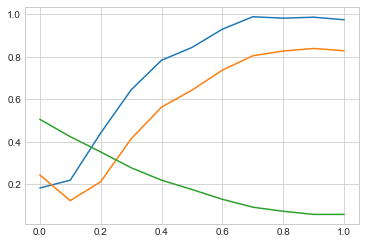

In [17]:
np.random.seed(42)
torch.manual_seed(42)
dataset_name='cora'
args_normalize = True
Y_Norm_Local_0hop_Global = []
Y_Norm_Local_1hop_Global = []
Y_Norm_Local_2hop_Global = []

for percent in range(0, 11, 1):
    
    iid_percent = percent / 10
    K_over_class_num = 1
    features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
    #if dataset_name=='simulate':
    #        feature = one_hot_labels
    if args_normalize:
        adj = normalize(adj)
    Norm_Local_0hop_Global = []
    Norm_Local_1hop_Global = []
    Norm_Local_2hop_Global = []
    
    

    for i in range(len(split_data_indexes)):
            current_index = split_data_indexes[i]
            Local_0hop = get_gradient_two_layer(features[current_index], adj[current_index][:,current_index], adj[current_index][:,current_index], len(current_index))

            neighbor1 = get_K_hop_neighbors(adj, current_index, 1)
            Local_1hop = get_gradient_two_layer(features[neighbor1], adj[current_index][:,neighbor1], adj[current_index][:,current_index], len(current_index))
 
            neighbor2 = get_K_hop_neighbors(adj, current_index, 2)

            Local_2hop = get_gradient_two_layer(features[neighbor2], adj[neighbor1][:,neighbor2], adj[current_index][:,neighbor1], len(current_index))
            #Local_comm = get_gradient_two_layer(features[neighbor2], adj[neighbor2][:,neighbor2], adj[neighbor2][:,neighbor2], len(neighbor2))

            Global = get_gradient_two_layer(features, adj, adj, len(adj))

            #print("Local_0hop", float(torch.norm(Local_0hop)))
            #print("Local_1hop", float(torch.norm(Local_1hop)))
            #print("Local_2hop", float(torch.norm(Local_2hop)))
            #print("Global", float(torch.norm(Global)))

            #print("Norm Local_comm Local_no_comm", float(torch.norm(Local_comm - Local_no_comm)))
            
            
            Norm_Local_0hop_Global.append(float(torch.norm(Local_0hop - Global)))
            Norm_Local_1hop_Global.append(float(torch.norm(Local_1hop - Global)))
            Norm_Local_2hop_Global.append(float(torch.norm(Local_2hop - Global)))
    print("Norm Local_0hop Global", np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    print("Norm Local_1hop Global", np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    print("Norm Local_2hop Global", np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
    Y_Norm_Local_0hop_Global.append(np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    Y_Norm_Local_1hop_Global.append(np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    Y_Norm_Local_2hop_Global.append(np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
            
            
np.save(dataset_name + "_Norm Local_0hop Global.npy", Y_Norm_Local_0hop_Global)
np.save(dataset_name + "_Norm Local_1hop Global.npy", Y_Norm_Local_1hop_Global)
np.save(dataset_name + "_Norm Local_2hop Global.npy", Y_Norm_Local_2hop_Global)


import matplotlib.pyplot as plt
X = np.array(range(0,11,1)) / 10

plt.plot(X, Y_Norm_Local_0hop_Global)
plt.plot(X, Y_Norm_Local_1hop_Global)
plt.plot(X, Y_Norm_Local_2hop_Global)

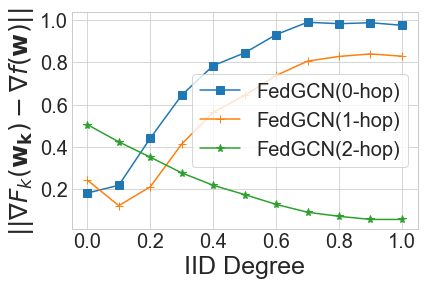

In [37]:
plt.style.use('seaborn-whitegrid')
dataset_name = 'cora'
Y_Norm_Local_0hop_Global = np.load(dataset_name + "_Norm Local_0hop Global.npy")
Y_Norm_Local_1hop_Global = np.load(dataset_name + "_Norm Local_1hop Global.npy")
Y_Norm_Local_2hop_Global = np.load(dataset_name + "_Norm Local_2hop Global.npy")

import matplotlib.pyplot as plt
X = np.array(range(0,11,1)) / 10

plt.plot(X, Y_Norm_Local_0hop_Global, 's-', label = 'FedGCN(0-hop)', markersize=8)
plt.plot(X, Y_Norm_Local_1hop_Global, '+-', label = 'FedGCN(1-hop)', markersize=8)
plt.plot(X, Y_Norm_Local_2hop_Global, '*-', label = 'FedGCN(2-hop)', markersize=8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, frameon=True, loc = 'best')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})



plt.xlabel('IID Degree', fontsize=25)
plt.ylabel(r'$\mathit{\|\|\nabla {F_k}(\mathbf{w_k}) - \nabla {f}(\mathbf{w})\|\|}$', fontsize=25)
plt.legend(fontsize=20, frameon=True, loc = 'best')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.savefig("cora_norm_data_distribution.png", format='png')

/Users/yhyao/Desktop/Federated-GCN/data_process.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


Norm Local_0hop Global 0.25205085674921673
Norm Local_1hop Global 0.24054845174153647
Norm Local_2hop Global 0.5709470907847086
Norm Local_0hop Global 0.3100669781366984
Norm Local_1hop Global 0.19661043087641397
Norm Local_2hop Global 0.4903782208760579
Norm Local_0hop Global 0.5727243224779764
Norm Local_1hop Global 0.34227676192919415
Norm Local_2hop Global 0.4015681942303975
Norm Local_0hop Global 0.7396322786808014
Norm Local_1hop Global 0.4948534270127614
Norm Local_2hop Global 0.3402838508288066
Norm Local_0hop Global 0.8605970939000448
Norm Local_1hop Global 0.6133410135904948
Norm Local_2hop Global 0.2826140522956848
Norm Local_0hop Global 0.9929401477177938
Norm Local_1hop Global 0.7560363213221232
Norm Local_2hop Global 0.2279285192489624
Norm Local_0hop Global 1.1250949104626973
Norm Local_1hop Global 0.898988684018453
Norm Local_2hop Global 0.16919797658920288
Norm Local_0hop Global 1.1436209678649902
Norm Local_1hop Global 0.9321180582046509
Norm Local_2hop Global 0.13873

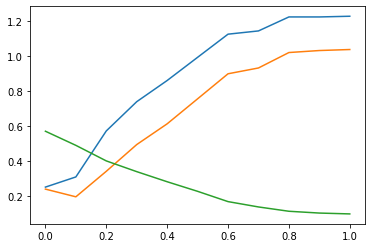

In [7]:
np.random.seed(42)
torch.manual_seed(42)
dataset_name='citeseer'
args_normalize = True
Y_Norm_Local_0hop_Global = []
Y_Norm_Local_1hop_Global = []
Y_Norm_Local_2hop_Global = []

for percent in range(0, 11, 1):
    
    iid_percent = percent / 10
    K_over_class_num = 1
    features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
    if dataset_name=='simulate':
            feature = one_hot_labels
    if args_normalize:
        adj = normalize(adj)
    Norm_Local_0hop_Global = []
    Norm_Local_1hop_Global = []
    Norm_Local_2hop_Global = []
    
    

    for i in range(len(split_data_indexes)):
            current_index = split_data_indexes[i]
            Local_0hop = get_gradient_two_layer(features[current_index], adj[current_index][:,current_index], adj[current_index][:,current_index], len(current_index))

            neighbor1 = get_K_hop_neighbors(adj, current_index, 1)
            Local_1hop = get_gradient_two_layer(features[neighbor1], adj[current_index][:,neighbor1], adj[current_index][:,current_index], len(current_index))
 
            neighbor2 = get_K_hop_neighbors(adj, current_index, 2)

            Local_2hop = get_gradient_two_layer(features[neighbor2], adj[neighbor1][:,neighbor2], adj[current_index][:,neighbor1], len(current_index))
            #Local_comm = get_gradient_two_layer(features[neighbor2], adj[neighbor2][:,neighbor2], adj[neighbor2][:,neighbor2], len(neighbor2))

            Global = get_gradient_two_layer(features, adj, adj, len(adj))

            #print("Local_0hop", float(torch.norm(Local_0hop)))
            #print("Local_1hop", float(torch.norm(Local_1hop)))
            #print("Local_2hop", float(torch.norm(Local_2hop)))
            #print("Global", float(torch.norm(Global)))

            #print("Norm Local_comm Local_no_comm", float(torch.norm(Local_comm - Local_no_comm)))
            
            
            Norm_Local_0hop_Global.append(float(torch.norm(Local_0hop - Global)))
            Norm_Local_1hop_Global.append(float(torch.norm(Local_1hop - Global)))
            Norm_Local_2hop_Global.append(float(torch.norm(Local_2hop - Global)))
    print("Norm Local_0hop Global", np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    print("Norm Local_1hop Global", np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    print("Norm Local_2hop Global", np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
    Y_Norm_Local_0hop_Global.append(np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    Y_Norm_Local_1hop_Global.append(np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    Y_Norm_Local_2hop_Global.append(np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
            
            
np.save(dataset_name + "_Norm Local_0hop Global.npy", Y_Norm_Local_0hop_Global)
np.save(dataset_name + "_Norm Local_1hop Global.npy", Y_Norm_Local_1hop_Global)
np.save(dataset_name + "_Norm Local_2hop Global.npy", Y_Norm_Local_2hop_Global)


import matplotlib.pyplot as plt
X = np.array(range(0,11,1)) / 10

plt.plot(X, Y_Norm_Local_0hop_Global)
plt.plot(X, Y_Norm_Local_1hop_Global)
plt.plot(X, Y_Norm_Local_2hop_Global)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
dataset_name='pubmed'
args_normalize = True
Y_Norm_Local_0hop_Global = []
Y_Norm_Local_1hop_Global = []
Y_Norm_Local_2hop_Global = []

for percent in range(0, 11, 1):
    
    iid_percent = percent / 10
    K_over_class_num = 1
    features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
    if dataset_name=='simulate':
            feature = one_hot_labels
    if args_normalize:
        adj = normalize(adj)
    Norm_Local_0hop_Global = []
    Norm_Local_1hop_Global = []
    Norm_Local_2hop_Global = []
    
    

    for i in range(len(split_data_indexes)):
            current_index = split_data_indexes[i]
            Local_0hop = get_gradient_two_layer(features[current_index], adj[current_index][:,current_index], adj[current_index][:,current_index], len(current_index))

            neighbor1 = get_K_hop_neighbors(adj, current_index, 1)
            Local_1hop = get_gradient_two_layer(features[neighbor1], adj[current_index][:,neighbor1], adj[current_index][:,current_index], len(current_index))
 
            neighbor2 = get_K_hop_neighbors(adj, current_index, 2)

            Local_2hop = get_gradient_two_layer(features[neighbor2], adj[neighbor1][:,neighbor2], adj[current_index][:,neighbor1], len(current_index))
            #Local_comm = get_gradient_two_layer(features[neighbor2], adj[neighbor2][:,neighbor2], adj[neighbor2][:,neighbor2], len(neighbor2))

            Global = get_gradient_two_layer(features, adj, adj, len(adj))

            #print("Local_0hop", float(torch.norm(Local_0hop)))
            #print("Local_1hop", float(torch.norm(Local_1hop)))
            #print("Local_2hop", float(torch.norm(Local_2hop)))
            #print("Global", float(torch.norm(Global)))

            #print("Norm Local_comm Local_no_comm", float(torch.norm(Local_comm - Local_no_comm)))
            
            
            Norm_Local_0hop_Global.append(float(torch.norm(Local_0hop - Global)))
            Norm_Local_1hop_Global.append(float(torch.norm(Local_1hop - Global)))
            Norm_Local_2hop_Global.append(float(torch.norm(Local_2hop - Global)))
    print("Norm Local_0hop Global", np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    print("Norm Local_1hop Global", np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    print("Norm Local_2hop Global", np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
    Y_Norm_Local_0hop_Global.append(np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    Y_Norm_Local_1hop_Global.append(np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    Y_Norm_Local_2hop_Global.append(np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
            
            
np.save(dataset_name + "_Norm Local_0hop Global.npy", Y_Norm_Local_0hop_Global)
np.save(dataset_name + "_Norm Local_1hop Global.npy", Y_Norm_Local_1hop_Global)
np.save(dataset_name + "_Norm Local_2hop Global.npy", Y_Norm_Local_2hop_Global)


import matplotlib.pyplot as plt
X = np.array(range(0,11,1)) / 10

plt.plot(X, Y_Norm_Local_0hop_Global)
plt.plot(X, Y_Norm_Local_1hop_Global)
plt.plot(X, Y_Norm_Local_2hop_Global)

Norm Local_0hop Global 0.013099101682504019
Norm Local_1hop Global 0.013330993553002676
Norm Local_2hop Global 0.01418765385945638
Norm Local_0hop Global 0.007563840597867966
Norm Local_1hop Global 0.008145480727156004
Norm Local_2hop Global 0.010731074959039688
Norm Local_0hop Global 0.00893832246462504
Norm Local_1hop Global 0.009670467426379522
Norm Local_2hop Global 0.012699653084079424
Norm Local_0hop Global 0.01313878440608581
Norm Local_1hop Global 0.013220059995849928
Norm Local_2hop Global 0.01391573871175448
Norm Local_0hop Global 0.006518740206956863
Norm Local_1hop Global 0.007397914305329323
Norm Local_2hop Global 0.011519746234019598
Norm Local_0hop Global 0.011766296190520128
Norm Local_1hop Global 0.01179900827507178
Norm Local_2hop Global 0.012102074300249418
Norm Local_0hop Global 0.005601602296034495
Norm Local_1hop Global 0.0057119814058144884
Norm Local_2hop Global 0.00950510986149311
Norm Local_0hop Global 0.006437601521611214
Norm Local_1hop Global 0.005517602898

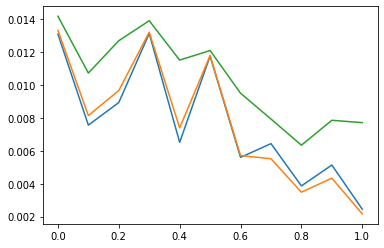

In [8]:
np.random.seed(42)
torch.manual_seed(42)
dataset_name='simulate'
args_normalize = True
Y_Norm_Local_0hop_Global = []
Y_Norm_Local_1hop_Global = []
Y_Norm_Local_2hop_Global = []

for percent in range(0, 11, 1):
    
    iid_percent = percent / 10
    K_over_class_num = 1
    features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
    if dataset_name=='simulate':
            feature = one_hot_labels
    if args_normalize:
        adj = normalize(adj)
    Norm_Local_0hop_Global = []
    Norm_Local_1hop_Global = []
    Norm_Local_2hop_Global = []
    
    

    for i in range(len(split_data_indexes)):
            current_index = split_data_indexes[i]
            Local_0hop = get_gradient_two_layer(features[current_index], adj[current_index][:,current_index], adj[current_index][:,current_index], len(current_index))

            neighbor1 = get_K_hop_neighbors(adj, current_index, 1)
            Local_1hop = get_gradient_two_layer(features[neighbor1], adj[current_index][:,neighbor1], adj[current_index][:,current_index], len(current_index))
 
            neighbor2 = get_K_hop_neighbors(adj, current_index, 2)

            Local_2hop = get_gradient_two_layer(features[neighbor2], adj[neighbor1][:,neighbor2], adj[current_index][:,neighbor1], len(current_index))
            #Local_comm = get_gradient_two_layer(features[neighbor2], adj[neighbor2][:,neighbor2], adj[neighbor2][:,neighbor2], len(neighbor2))

            Global = get_gradient_two_layer(features, adj, adj, len(adj))

            #print("Local_0hop", float(torch.norm(Local_0hop)))
            #print("Local_1hop", float(torch.norm(Local_1hop)))
            #print("Local_2hop", float(torch.norm(Local_2hop)))
            #print("Global", float(torch.norm(Global)))

            #print("Norm Local_comm Local_no_comm", float(torch.norm(Local_comm - Local_no_comm)))
            
            
            Norm_Local_0hop_Global.append(float(torch.norm(Local_0hop - Global)))
            Norm_Local_1hop_Global.append(float(torch.norm(Local_1hop - Global)))
            Norm_Local_2hop_Global.append(float(torch.norm(Local_2hop - Global)))
    print("Norm Local_0hop Global", np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    print("Norm Local_1hop Global", np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    print("Norm Local_2hop Global", np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
    Y_Norm_Local_0hop_Global.append(np.array(Norm_Local_0hop_Global).sum() / len(Norm_Local_0hop_Global))
    Y_Norm_Local_1hop_Global.append(np.array(Norm_Local_1hop_Global).sum() / len(Norm_Local_1hop_Global))
    Y_Norm_Local_2hop_Global.append(np.array(Norm_Local_2hop_Global).sum() / len(Norm_Local_2hop_Global))
            
            
np.save(dataset_name + "_Norm Local_0hop Global.npy", Y_Norm_Local_0hop_Global)
np.save(dataset_name + "_Norm Local_1hop Global.npy", Y_Norm_Local_1hop_Global)
np.save(dataset_name + "_Norm Local_2hop Global.npy", Y_Norm_Local_2hop_Global)


import matplotlib.pyplot as plt
X = np.array(range(0,11,1)) / 10

plt.plot(X, Y_Norm_Local_0hop_Global)
plt.plot(X, Y_Norm_Local_1hop_Global)
plt.plot(X, Y_Norm_Local_2hop_Global)